In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

import sympy as sym

from table_maker import *
from functools import partial
from itertools import *
from math import ceil

import pickle

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

Adapted from [Kilpatrick and Bressloff 2010](https://doi.org/10.1016/j.physd.2009.06.003)
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,y) q(y,t) f\big( u(y,t)\big) \ dy \\
    \alpha q_t &= 1 - q - \alpha\beta q f(u) \\
\end{align*}$$

In [95]:
θ = .2
α = 20
β = .25
μ = 1

###############################################

a, b = -50, 100
n = 10**3 * 2

###############################################
xs = np.linspace(a,b,n)
h = (b-a)/(n-1)

def firing_rate(u):
    return np.heaviside(u-θ, .5)
    
M = .5*np.exp( - np.abs( np.subtract.outer(xs, xs) ) ) * h

# def convolution(u):
#     return M@firing_rate(u)

def RK4_step(F, t, u, dt):
    k1 = F(t,u)
    k2 = F(t+dt/2, u + dt/2*k1)
    k3 = F(t+dt/2, u + dt/2*k2)
    k4 = F(t+dt, u + dt*k3)
    return u + dt/6*(k1+2*k2+2*k3+k4)

# u is a vector [u, q]
def F(t,u):
    temp_var = firing_rate(u[0])
    ret = np.array([
        1/μ * (-u[0] + M@(u[1]*temp_var)),
        (1-u[1])/α - β*u[1]*temp_var
    ])
    return ret

def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)

In [96]:
# Numerical functions
def Unum(ξ, θ, α, β, μ, c, Δ):
    return ((( lambda base, exponent: base**exponent )(α, 4)*β*( lambda base, exponent: base**exponent )(c, 2)*np.exp(Δ/(μ*c) - Δ*(α*β + 1)/(α*c))/((α - μ*(α*β + 1))*(α*β + 1)*(-α*β + α*c - 1)*(α*β + α*c + 1)) - ( lambda base, exponent: base**exponent )(α, 4)*β*( lambda base, exponent: base**exponent )(c, 2)/((α - μ*(α*β + 1))*(α*β + 1)*(-α*β + α*c - 1)*(α*β + α*c + 1)) + np.exp(Δ/(μ*c))/(α*β + 1) - 1/(α*β + 1) - 1.0/2.0*(( lambda base, exponent: base**exponent )(α, 2)*β*c*np.exp(Δ) + (α*β + α*c + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)))*np.exp(-Δ*(α*β + 2*α*c + 1)/(α*c))*np.exp(Δ + Δ/(μ*c))/((α*β + 1)*(μ*c + 1)*(α*β + α*c + 1)) + (1.0/2.0)*(( lambda base, exponent: base**exponent )(α, 2)*β*c*np.exp(Δ) + (α*β + α*c + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)))*np.exp(-Δ*(α*β + 2*α*c + 1)/(α*c))/((α*β + 1)*(μ*c + 1)*(α*β + α*c + 1)) + (1.0/2.0)*(-( lambda base, exponent: base**exponent )(α, 2)*β*c + α*c*(α*β + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)) - α*c*np.exp(Δ*(α*β + 1)/(α*c)) - (α*β + 1)*np.exp(Δ*(α*β + 1)/(α*c)) + (α*β + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)))*np.exp(-Δ*(α*β + α*c + 1)/(α*c))/((α*β + 1)*(μ*c + 1)*(α*β + α*c + 1)) - 1.0/2.0*(( lambda base, exponent: base**exponent )(α, 2)*β*c*np.exp(Δ) - α*c*(α*β - np.exp(Δ) + 1)*np.exp(Δ*(α*β + 1)/(α*c)) + (1 - np.exp(Δ))*(α*β + 1)*np.exp(Δ*(α*β + 1)/(α*c)))*np.exp(-Δ*(α*β + 1)/(α*c))*np.exp(-Δ + Δ/(μ*c))/((α*β + 1)*(μ*c - 1)*(α*β - α*c + 1)) + (1.0/2.0)*(-( lambda base, exponent: base**exponent )(α, 2)*β*c + α*β - α*c + 1)*np.exp(-Δ + Δ/(μ*c))/((α*β + 1)*(μ*c - 1)*(-α*β + α*c - 1)) - 1.0/2.0*(-( lambda base, exponent: base**exponent )(α, 2)*β*c + α*β - α*c + 1)/((α*β + 1)*(μ*c - 1)*(-α*β + α*c - 1)))*np.exp(ξ/(μ*c)) + (1.0/2.0)*(( lambda base, exponent: base**exponent )(α, 2)*β*c*np.exp(Δ) - α*c*(α*β - np.exp(Δ) + 1)*np.exp(Δ*(α*β + 1)/(α*c)) + (1 - np.exp(Δ))*(α*β + 1)*np.exp(Δ*(α*β + 1)/(α*c)))*np.exp(ξ)*np.exp(-Δ*(α*β + 1)/(α*c))/((α*β + 1)*(μ*c - 1)*(α*β - α*c + 1)))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + (( lambda base, exponent: base**exponent )(α, 4)*β*( lambda base, exponent: base**exponent )(c, 2)*np.exp(ξ*(α*β + 1)/(α*c))/((α - μ*(α*β + 1))*(α*β + 1)*(-α*β + α*c - 1)*(α*β + α*c + 1)) + (-( lambda base, exponent: base**exponent )(α, 4)*β*( lambda base, exponent: base**exponent )(c, 2)/((α - μ*(α*β + 1))*(α*β + 1)*(-α*β + α*c - 1)*(α*β + α*c + 1)) - 1/(α*β + 1) + (1.0/2.0)*(( lambda base, exponent: base**exponent )(α, 2)*β*c*np.exp(Δ) + (α*β + α*c + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)))*np.exp(-Δ*(α*β + 2*α*c + 1)/(α*c))/((α*β + 1)*(μ*c + 1)*(α*β + α*c + 1)) + (1.0/2.0)*(-( lambda base, exponent: base**exponent )(α, 2)*β*c + α*c*(α*β + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)) - α*c*np.exp(Δ*(α*β + 1)/(α*c)) - (α*β + 1)*np.exp(Δ*(α*β + 1)/(α*c)) + (α*β + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)))*np.exp(-Δ*(α*β + α*c + 1)/(α*c))/((α*β + 1)*(μ*c + 1)*(α*β + α*c + 1)) - 1.0/2.0*(-( lambda base, exponent: base**exponent )(α, 2)*β*c + α*β - α*c + 1)/((α*β + 1)*(μ*c - 1)*(-α*β + α*c - 1)))*np.exp(ξ/(μ*c)) + 1.0/(α*β + 1) - 1.0/2.0*(( lambda base, exponent: base**exponent )(α, 2)*β*c*np.exp(Δ) + (α*β + α*c + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)))*np.exp(-ξ)*np.exp(-Δ*(α*β + 2*α*c + 1)/(α*c))/((α*β + 1)*(μ*c + 1)*(α*β + α*c + 1)) + (1.0/2.0)*(-( lambda base, exponent: base**exponent )(α, 2)*β*c + α*β - α*c + 1)*np.exp(ξ)/((α*β + 1)*(μ*c - 1)*(-α*β + α*c - 1)))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ) + (1.0/2.0)*(-( lambda base, exponent: base**exponent )(α, 2)*β*c + α*c*(α*β + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)) - α*c*np.exp(Δ*(α*β + 1)/(α*c)) - (α*β + 1)*np.exp(Δ*(α*β + 1)/(α*c)) + (α*β + 1)*np.exp(Δ*(α*β + α*c + 1)/(α*c)))*np.exp(-ξ*(1 + 1/(μ*c)))*np.exp(-Δ*(α*β + α*c + 1)/(α*c))*(lambda input: np.heaviside(input,0.5))(ξ)/((α*β + 1)*(μ*c + 1)*(α*β + α*c + 1))
def Qnum(ξ, θ, α, β, μ, c, Δ):
    return (α*β*(-np.exp(Δ/(α*c)) + np.exp(-Δ*β/c))*np.exp(ξ/(α*c))/(α*β + 1) + 1)*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + (lambda input: np.heaviside(input,0.5))(ξ) + (α*β*np.exp(ξ*(α*β + 1)/(α*c)) + 1)*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ)/(α*β + 1)

In [148]:
u0 = np.zeros((2,n))

# u0[0] = cos_bell(xs, center=0, width=100)
# u0[1] += 1 # Set initial q to 1

# with open('u0_pulse.pickle', 'rb') as f:
#     u0 = pickle.load(f)
#     assert u0.shape[1] == xs.shape[0]
params = {
    'θ': 0.2,
    'α': 20,
    'β': 0.25,
    'μ': 1,
    'c': 1.0192596298149075, #1.0300494800633475,
    'Δ': 9.30465232616308, #9.398164502290209
}
u0[0] = Unum(xs-20, **params)
u0[1] = Qnum(xs-20, **params)

t0 = 0
t_final = 60
k = 1e-2

########################
steps = int(np.ceil( (t_final - t0)/k ))
k = (t_final - t0)/steps

us = [u0]
ts = [t0]

for step in range(steps):
    ts += [ts[-1] + k]
    us += [ RK4_step(F, ts[-1], us[-1], k) ]
    print('step %d/%d' % (step,steps), end='\r')

In [149]:
y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max

stride = 20

fig, ax = plt.subplots(1, 1, figsize=(12,8))

line_u, = ax.plot(xs, us[0][0], 'b-', label="$u$")
line_q, = ax.plot(xs, us[0][1], 'g-', label="$q$")
ax.plot([a, b], [θ]*2, 'k:')
ax.legend(loc='right')
ax.set_ylim(*window)
ax.set_xlim(0, b)
# ax.set_xlim(a,b)

def animate(i):
    print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_q.set_ydata(us[i][1])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, np.arange(0,len(ts),stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('negative-feedback_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

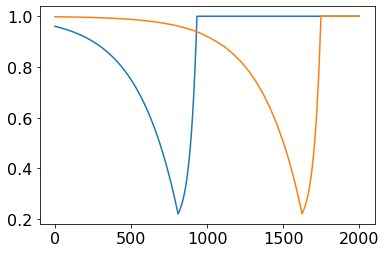

In [150]:
plt.plot(us[0][1])
plt.plot(us[-1][1])

In [154]:
i_start = np.argmax(us[0][1])
i_stop = np.argmax(us[-1][1])
c_approx = (xs[i_stop] - xs[i_start])/(t_final)
print(c_approx)
print(c)

1.0192596298149075
1.0300494800633475


In [156]:
index1 = np.argmin(np.abs(us[-1][0][:1700] - θ))
index2 = np.argmin(np.abs(us[-1][0][1700:] - θ)) + 1700
Δ_approx = xs[index2] - xs[index1]
print(Δ_approx)
print(Δ)

9.30465232616308
9.398164502290209


In [157]:
h

0.0750375187593797

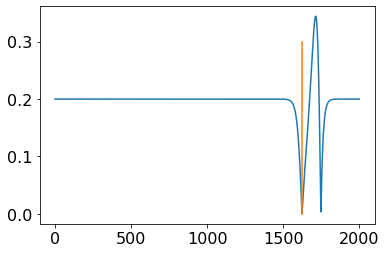

In [153]:
plt.plot(np.abs(us[-1][0] - θ))
plt.plot([index1]*2, [0, .3])